# 3주차 Multilayer perceptron

<img src='https://d2l.ai/_images/mlp.svg'>




## 3.1 Activation function

In [1]:
!pip install --quiet d2l

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l
import warnings
warnings.filterwarnings("ignore")

### a. ReLU

현재까지 널리 사용되면서, 적용하기 쉬운 비선형 활성화 함수 *rectified linear unit* **(ReLU)** 함수를 그려봅시다.


$$ \texttt{ReLU}(x)=\max\{x, 0\} $$



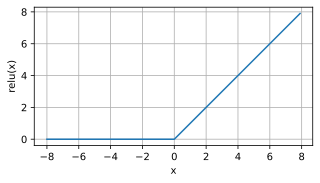

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5)) # detach() -> grad 계산을 하지 않는 상태의 tensor를 반환


ReLU 함수의 미분꼴은 *heavyside function* 입니다.

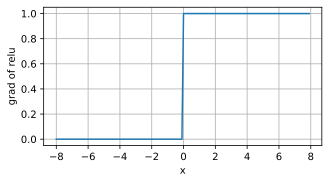

In [4]:
y.backward(torch.ones_like(x), retain_graph=True) #x.grad에 기울기가 저장됨
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

* ReLU 함수를 직접 구현해봅시다!

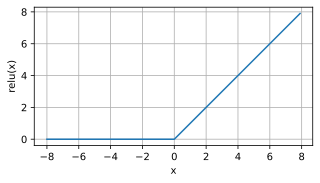

In [5]:
# x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True) -> x 새로 선언하면 x.grad가 None이라서 오류
y = x * (x > 0).float() # torch 라이브러리 없이 구현

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

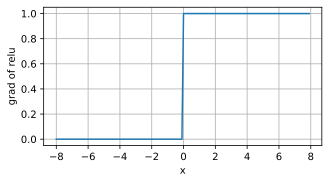

In [6]:
# Clear out previous gradients
x.grad.data.zero_()

y.backward(torch.ones_like(x), retain_graph=True) # Tensor.backward(gradient, retain_graph) # 디폴트 backward() -> backward(gradient=torch.Tensor([1.]))
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### b. Sigmoid

Sigmoid 함수는 실수 전체 $\mathbb{R}$ 도메인을 $(0, 1)$ 구간으로 맵핑하는 함수입니다.

$$ \texttt{Sigmoid}(x)={1\over 1+\exp(-x)}  $$


기울기 기반 학습 과정에서 sigmoid 는 부드럽고 미분가능한 좋은 성질을 가진 함수입니다.

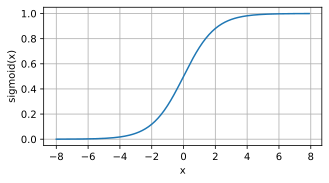

In [7]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

한편 sigmoid 함수의 미분은 다시 자기자신을 이용한 형태로 나타납니다.

$$ {d\over dx}\texttt{sigmoid}(x)={\exp(-x)\over(1+\exp(-x))^2}=\texttt{sigmoid}(x)(1-\texttt{sigmoid}(x)). $$

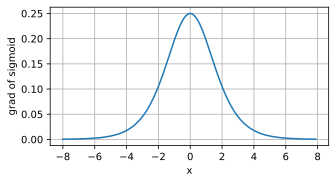

In [8]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)

d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

* Sigmoid 함수를 직접 구현해봅시다!

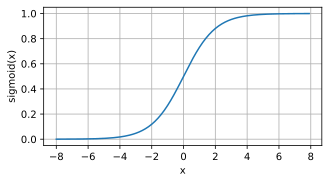

In [9]:
y = (1.0 / (1.0 + 2.7183**(-x))).float() # e = 2.7183

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

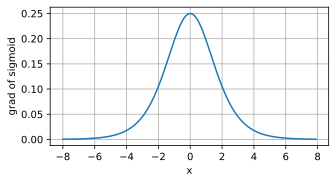

In [10]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## 3.2 MLP implementation



In [11]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer ##, load_digits, load_wine ##

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1. Load dataset

In [12]:
data = load_breast_cancer()

In [13]:
input = data.data # input.shape -> (569,30)
output = data.target # output shape -> (569, )

* GPU 사용이 가능하다면 device 를 GPU 로 설정!

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

* 데이터를 미리 설정한 device 로 이동합니다.

In [15]:
## Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True) # ML에서 사용하던 train_test_split # train 크기 : test 크기 = 7 : 3

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [16]:
print(x_train[0]) # x_train.shape -> torch.Size([398, 30])
print(y_train[0]) # y_train.shape -> torch.Size([398])

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


## Step 2 : CustomDataset 과 DataLoader

In [17]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [18]:
batch_size = 8
dataset = CustomDataset() #선언함으로써 dataset.x_data에는 x_train이, dataset.y_data에는 변형된 y_train이 할당됨
dataloader = DataLoader(dataset, batch_size=batch_size)

## Step 3 : Define "Model"

* activation function 이용

  * nn.Sigmoid()
  * nn.ReLU()
  * nn.tanH()


* batch normazliation 1d 란?
  * 파라미터 값으로 vector의 길이를 전해줌



* a. 직접 nn.Sequential() 로 구현하기

In [19]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

* b. 파이썬 Class 로 구현하기

In [20]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398) # 데이터 정규화 [평균: 0 , 분산: 1]
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398, 15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer2 = 15, hidden_layer3 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, y_len, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

* Weight initialization

In [21]:
def init_weights(layer):
    if isinstance(layer, nn.Linear): #layer이 nn.Linear면 True를 반환
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [22]:
model = Model().to(device)
model.apply(init_weights) #Tanh or Sigmoid 활성화 함수 [중앙부분이 Linear] -> Xavier Initialization, ReLU or Similar 활성화 함수 -> Kaiming [a.k.a. He] Initialization

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


## Step 4 : Loss function 과 Optimizer

* 다양한 optimizer 가 존재
  * https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [23]:
loss_fn  = nn.CrossEntropyLoss().to(device) #회귀보다는 분류에 적합한 손실함수 (회귀에는 MSE, MAE)

In [24]:
optimizer = optim.Adam(model.parameters(), lr= 0.01) # Adam = Adagrad(이제까지의 Gradients를 기반으로 한 Adaptive Learning Rate) + SGDMomentum(과거의 진행방향을 반영)

## Step 5: Train Model

In [25]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train) # hypothesis.shape -> torch.Size([398, 2])

  # 비용 함수
  cost = loss_fn(hypothesis, y_train) # y_train.shape -> torch.Size([398])
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 0.6551404595375061
10 0.5041946172714233
20 0.41785070300102234
30 0.3969472348690033
40 0.3946632742881775
50 0.38842934370040894
60 0.3916560709476471
70 0.4040249288082123
80 0.3831358850002289
90 0.4137938916683197


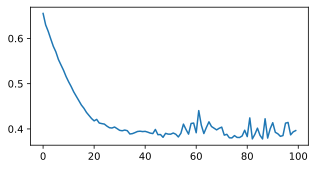

In [26]:
plt.plot(losses)
plt.show()

In [27]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1) # 각 행에서 가장 높은 값을 가진 인덱스 반환
  accuracy = (accuracy_score(predicted, y_test))

In [28]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.00381211 0.99618787]
argmax를 한 후의 output은 1
accuracy는 0.9005847953216374


# MLP 를 다뤄봅시다! *****여기서부터*****


위 코드를 참고하여 직접 MLP 를 구현해봅시다.

load_digits() 또는 load_wine() 중 하나를 골라 시도해보세요!

- lr, optimizer, hidden layer(depth), neuron 수(width)를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!

In [29]:
from sklearn.datasets import load_digits #손글씨로 쓴 숫자를 분류하는 데이터 셋

In [30]:
# 데이터셋을 data에 할당

data = load_digits()

In [31]:
# data를 input & output으로 나눠서 할당

input = data.data # input.shape -> (1797, 64)
output = data.target # output.shape -> (1797,)

In [32]:
# GPU 우선사용으로 설정
## 왜? GPU는 병렬 처리에 뛰어나므로 고도로 병렬화 가능한 작업에 이상적이기 때문

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(26)
if device == "cuda":
  torch.cuda.manual_seed_all(26)

In [33]:
# input & output을 train용 & test용으로 적절히 분배하기

x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True) # train 크기 : test 크기 = 7 : 3

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

x_len = len(x_train[0]) # x_len == 64
y_len = len(y_train.unique()) # y_len == 10

여기에서는 dataset과 dataloader를 정의만 해주고 사용은 안했습니다!

In [34]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
  def __init__(self): #  데이터셋의 전처리를 해주는 부분
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
    # tensor([0, 7, 1,  ..., 1, 0, 8]) 텐서형태 -> [[tensor(0)], [tensor(7)], ..., [tensor(0)], [tensor(8)]] 리스트형태
    ## x_train 각각의 데이터에 상응하기 위해서 이와 같이 y_train 전처리 진행

  def __len__(self): #  데이터셋의 길이. 즉, 총 샘플의 수 (여기에서는 8) 를 적어주는 부분
    return len(self.x_data)


  def __getitem__(self, idx): #  데이터셋에서 특정 1개의 샘플을 가져오는 함수
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x,y

In [35]:
# 데이터 샘플을 처리하는 코드

batch_size = 8
dataset = CustomDataset() # CustomDataset(Dataset) 선언함으로써 x_train & y_train을 저장함
dataloader = DataLoader(dataset, batch_size=batch_size) # DataLoader 선언함으로써 dataset 내 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌈

## 1번째 모델 [Depth : 3층] [Width : 64 -> 400 -> 200 -> 10]

In [36]:
# 파이썬 Class를 이용한 모델 구축

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,400, bias=True), # input_layer = 64, hidden_layer1 = 400
          nn.SiLU(),
          # 활성화함수로는 가장 최근에 제안된 SiLU (a.k.a. Swish) 사용함
          ## 왜? 넓은 범위에 값에도 안정적인 결과를 보여주고 Dying ReLU를 방지함
        nn.BatchNorm1d(400) # 데이터 정규화 [평균: 0 , 분산: 1]
    )
    self.layer2 = nn.Sequential(
          nn.Linear(400, 200, bias=True), # hidden_layer1 = 400, hidden_layer2 = 200
          nn.SiLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(200, y_len, bias=True), # hidden_layer2 = 200, output_layer = 10
          nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    return output

In [37]:
# 가중치 초기화 및 적용

model = Model().to(device)

def init_weights(layer):
    if isinstance(layer, nn.Linear): #layer이 nn.Linear면 True를 반환
        torch.nn.init.kaiming_uniform_(layer.weight) #SiLU (a.k.a. Swish)는 변형된 ReLU의 한 형태이기에 Xavier보다는 Kaiming 초기화가 성능이 더 좋음
        layer.bias.data.fill_(0.01)

model.apply(init_weights)
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=400, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): SiLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [38]:
# 손실함수 설정

loss_fn  = nn.CrossEntropyLoss().to(device)
# Softmax 함수의 손실함수로 CrossEntropyLoss를 사용하면 Backpropagation때 (예측값 - 실제값)으로 말끔히 떨어짐
## 왜? CrossEntropyLoss가 그렇게 설계되었기 때문

In [39]:
# 옵티마이저 설정

optimizers = [(optim.Adam(model.parameters(), lr= 0.01)), (optim.Adam(model.parameters(), lr= 0.001)), (optim.Adam(model.parameters(), lr= 0.1)),
              (optim.RMSprop(model.parameters(), lr= 0.01)), (optim.RMSprop(model.parameters(), lr= 0.001)), (optim.RMSprop(model.parameters(), lr= 0.1)),
              (optim.SGD(model.parameters(), lr= 0.01)), (optim.SGD(model.parameters(), lr= 0.001)), (optim.SGD(model.parameters(), lr= 0.1))]
# Adam = RMSProp + SGDMomentum
# RMSProp = Adaptive Learning Rate를 가진 SGD

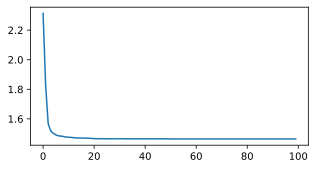

0.01의 학습률을 가진 Adam 옵티마이저는 96.85퍼센트의 정확도를 가집니다. 





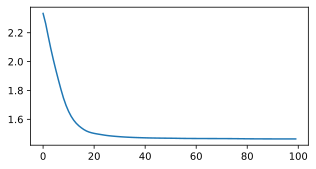

0.001의 학습률을 가진 Adam 옵티마이저는 97.96퍼센트의 정확도를 가집니다. 





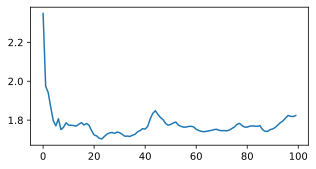

0.1의 학습률을 가진 Adam 옵티마이저는 63.33퍼센트의 정확도를 가집니다. 





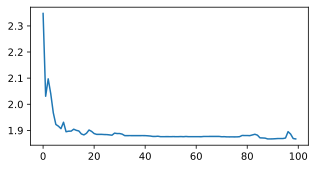

0.01의 학습률을 가진 RMSprop 옵티마이저는 57.78퍼센트의 정확도를 가집니다. 





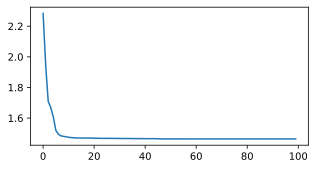

0.001의 학습률을 가진 RMSprop 옵티마이저는 97.78퍼센트의 정확도를 가집니다. 





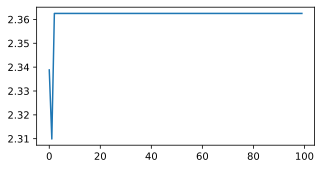

0.1의 학습률을 가진 RMSprop 옵티마이저는 10.00퍼센트의 정확도를 가집니다. 





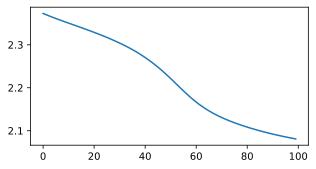

0.01의 학습률을 가진 SGD 옵티마이저는 35.56퍼센트의 정확도를 가집니다. 





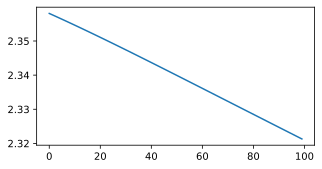

0.001의 학습률을 가진 SGD 옵티마이저는 10.93퍼센트의 정확도를 가집니다. 





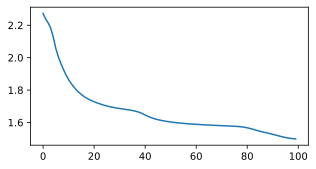

0.1의 학습률을 가진 SGD 옵티마이저는 93.15퍼센트의 정확도를 가집니다. 





In [40]:
# 모델 학습

for optimizer in optimizers:

  losses = []
  learning_rate = optimizer.param_groups[0]['lr']
  model.apply(init_weights) # 매 옵티마이저마다 가중치 초기화

  for epoch in range(100):

    optimizer.zero_grad() # 옵티마이저 초기화
    hypothesis = model(x_train) # 구축한 모델 기반으로 예측값 계산

    cost = loss_fn(hypothesis, y_train) # 손실함수를 이용한 손실값 계산
    cost.backward() # 손실값 기반 Backpropagation
    with torch.no_grad():
      optimizer.step() # 옵티마이저 실행 -> 가중치 업데이트
    losses.append(cost.item()) # 손실값 저장 for 진행상황 파악

  #  손실값 변화 시각화
  plt.plot(losses)
  plt.show()

  # Test Data로 Model 평가
  with torch.no_grad():
    model = model.to('cpu')
    y_pred = model(x_test)
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis =1) # 각 행에서 가장 높은 값을 가진 인덱스 반환
    accuracy = (accuracy_score(predicted, y_test))

  # 평가 결과 출력
  print(f'{learning_rate}의 학습률을 가진 {(type (optimizer).__name__)} 옵티마이저는 {accuracy*100.0:.2f}퍼센트의 정확도를 가집니다. \n\n\n')


## 모델 길이를 늘려볼까?



## 2번째 모델 [Depth : 4층] [Width : 64 -> 400 -> 200 -> 50 -> 10]


진행과정은 동일


In [41]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,400, bias=True), # input_layer = 64, hidden_layer1 = 400
          nn.SiLU(),
        nn.BatchNorm1d(400)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(400, 200, bias=True), # hidden_layer1 = 400, hidden_layer2 = 200
          nn.SiLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(200, 50, bias=True), # hidden_layer2 = 200, hidden_layer3 = 50
          nn.SiLU()
    )
    self.layer4 = nn.Sequential(
          nn.Linear(50, y_len, bias=True), # hidden_layer3 = 50, output_layer = 10
          nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [42]:
model = Model().to(device)

model.apply(init_weights)
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=400, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): SiLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=200, out_features=50, bias=True)
    (1): SiLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [43]:
optimizers = [(optim.Adam(model.parameters(), lr= 0.01)), (optim.Adam(model.parameters(), lr= 0.001)), (optim.Adam(model.parameters(), lr= 0.1)),
              (optim.RMSprop(model.parameters(), lr= 0.01)), (optim.RMSprop(model.parameters(), lr= 0.001)), (optim.RMSprop(model.parameters(), lr= 0.1)),
              (optim.SGD(model.parameters(), lr= 0.01)), (optim.SGD(model.parameters(), lr= 0.001)), (optim.SGD(model.parameters(), lr= 0.1))]

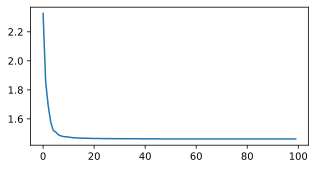

0.01의 학습률을 가진 Adam 옵티마이저는 96.48퍼센트의 정확도를 가집니다. 





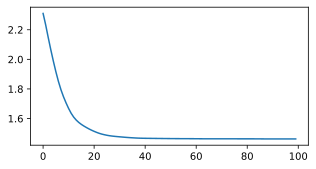

0.001의 학습률을 가진 Adam 옵티마이저는 97.04퍼센트의 정확도를 가집니다. 





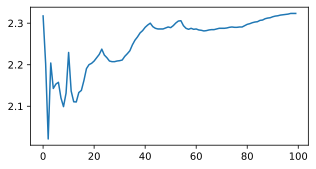

0.1의 학습률을 가진 Adam 옵티마이저는 14.26퍼센트의 정확도를 가집니다. 





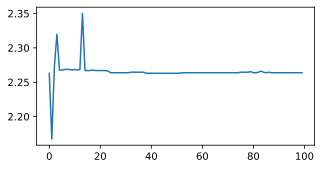

0.01의 학습률을 가진 RMSprop 옵티마이저는 19.44퍼센트의 정확도를 가집니다. 





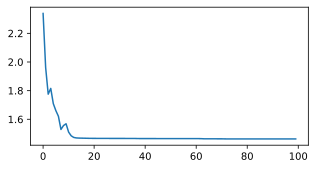

0.001의 학습률을 가진 RMSprop 옵티마이저는 98.15퍼센트의 정확도를 가집니다. 





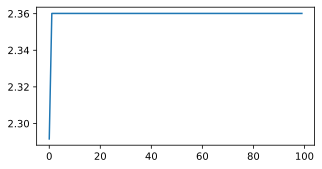

0.1의 학습률을 가진 RMSprop 옵티마이저는 10.19퍼센트의 정확도를 가집니다. 





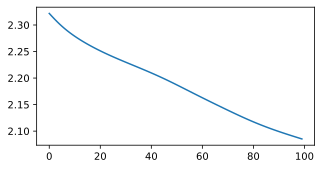

0.01의 학습률을 가진 SGD 옵티마이저는 38.52퍼센트의 정확도를 가집니다. 





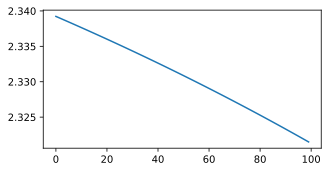

0.001의 학습률을 가진 SGD 옵티마이저는 8.33퍼센트의 정확도를 가집니다. 





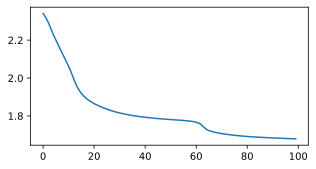

0.1의 학습률을 가진 SGD 옵티마이저는 75.93퍼센트의 정확도를 가집니다. 





In [44]:
for optimizer in optimizers:

  losses = []
  learning_rate = optimizer.param_groups[0]['lr']
  model.apply(init_weights) # 매 옵티마이저마다 가중치 초기화

  for epoch in range(100):

    optimizer.zero_grad() # 옵티마이저 초기화
    hypothesis = model(x_train) # 구축한 모델 기반으로 예측값 계산

    cost = loss_fn(hypothesis, y_train) # 손실함수를 이용한 손실값 계산
    cost.backward() # 손실값 기반 Backpropagation
    with torch.no_grad():
      optimizer.step() # 옵티마이저 실행 -> 가중치 업데이트
    losses.append(cost.item()) # 손실값 저장 for 진행상황 파악

  #  손실값 변화 시각화
  plt.plot(losses)
  plt.show()

  # Test Data로 Model 평가
  with torch.no_grad():
    model = model.to('cpu')
    y_pred = model(x_test)
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis =1) # 각 행에서 가장 높은 값을 가진 인덱스 반환
    accuracy = (accuracy_score(predicted, y_test))

  # 평가 결과 출력
  print(f'{learning_rate}의 학습률을 가진 {(type (optimizer).__name__)} 옵티마이저는 {accuracy*100.0:.2f}퍼센트의 정확도를 가집니다. \n\n\n')

## 모델 너비를 줄여볼까?

## 3번째 모델 [Depth : 5층] [Width : 64 -> 100 -> 50 -> 15 -> 10]

모델의 깊이랑 너비만 다르고 진행과정은 동일

In [45]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,100, bias=True), # input_layer = 64, hidden_layer1 = 100
          nn.SiLU(),
        nn.BatchNorm1d(100)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(100, 50, bias=True), # hidden_layer1 = 100, hidden_layer2 = 50
          nn.SiLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(50, 15, bias=True), # hidden_layer2 = 50, hidden_layer3 = 15
          nn.SiLU()
    )
    self.layer4 = nn.Sequential(
          nn.Linear(15, y_len, bias=True), # hidden_layer3 = 15, output_layer = 10
          nn.Softmax()
    )


  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [46]:
model = Model().to(device)

model.apply(init_weights)
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): SiLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=50, out_features=15, bias=True)
    (1): SiLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [47]:
optimizers = [(optim.Adam(model.parameters(), lr= 0.01)), (optim.Adam(model.parameters(), lr= 0.001)), (optim.Adam(model.parameters(), lr= 0.1)),
              (optim.RMSprop(model.parameters(), lr= 0.01)), (optim.RMSprop(model.parameters(), lr= 0.001)), (optim.RMSprop(model.parameters(), lr= 0.1)),
              (optim.SGD(model.parameters(), lr= 0.01)), (optim.SGD(model.parameters(), lr= 0.001)), (optim.SGD(model.parameters(), lr= 0.1))]

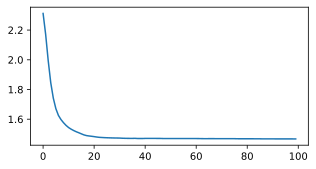

0.01의 학습률을 가진 Adam 옵티마이저는 96.30퍼센트의 정확도를 가집니다. 





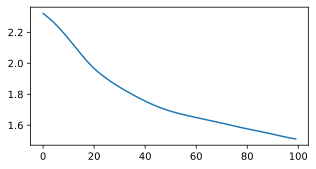

0.001의 학습률을 가진 Adam 옵티마이저는 93.89퍼센트의 정확도를 가집니다. 





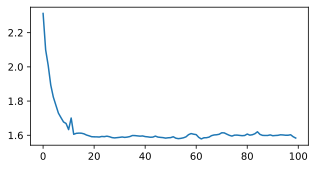

0.1의 학습률을 가진 Adam 옵티마이저는 85.56퍼센트의 정확도를 가집니다. 





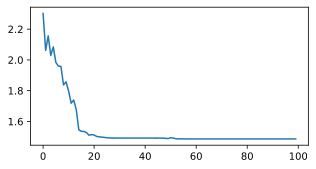

0.01의 학습률을 가진 RMSprop 옵티마이저는 93.89퍼센트의 정확도를 가집니다. 





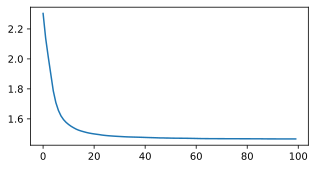

0.001의 학습률을 가진 RMSprop 옵티마이저는 95.19퍼센트의 정확도를 가집니다. 





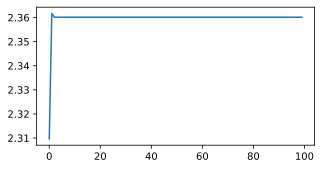

0.1의 학습률을 가진 RMSprop 옵티마이저는 10.19퍼센트의 정확도를 가집니다. 





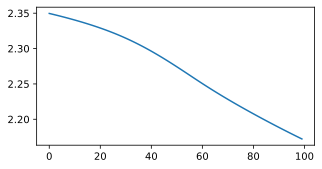

0.01의 학습률을 가진 SGD 옵티마이저는 28.15퍼센트의 정확도를 가집니다. 





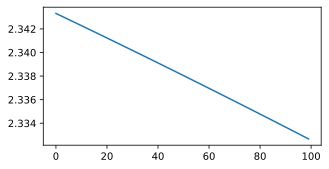

0.001의 학습률을 가진 SGD 옵티마이저는 8.89퍼센트의 정확도를 가집니다. 





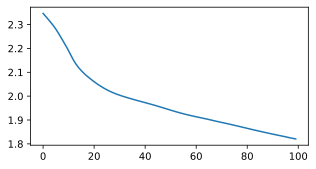

0.1의 학습률을 가진 SGD 옵티마이저는 62.59퍼센트의 정확도를 가집니다. 





In [48]:
for optimizer in optimizers:

  losses = []
  learning_rate = optimizer.param_groups[0]['lr']
  model.apply(init_weights) # 매 옵티마이저마다 가중치 초기화

  for epoch in range(100):

    optimizer.zero_grad() # 옵티마이저 초기화
    hypothesis = model(x_train) # 구축한 모델 기반으로 예측값 계산

    cost = loss_fn(hypothesis, y_train) # 손실함수를 이용한 손실값 계산
    cost.backward() # 손실값 기반 Backpropagation
    with torch.no_grad():
      optimizer.step() # 옵티마이저 실행 -> 가중치 업데이트
    losses.append(cost.item()) # 손실값 저장 for 진행상황 파악

  #  손실값 변화 시각화
  plt.plot(losses)
  plt.show()

  # Test Data로 Model 평가
  with torch.no_grad():
    model = model.to('cpu')
    y_pred = model(x_test)
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis =1) # 각 행에서 가장 높은 값을 가진 인덱스 반환
    accuracy = (accuracy_score(predicted, y_test))

  # 평가 결과 출력
  print(f'{learning_rate}의 학습률을 가진 {(type (optimizer).__name__)} 옵티마이저는 {accuracy*100.0:.2f}퍼센트의 정확도를 가집니다. \n\n\n')

**결론 : 2번째 모델에서 0.001의 학습률을 가진 RMSprop 옵티마이저가 98.15%라는 수치로 정확도로 가장 높았습니다.**